# Машинное обучение

## Факультет математики НИУ ВШЭ

### 2019-2020 учебный год

Илья Щуров, Соня Дымченко, Руслан Хайдуров, Павел Балтабаев, Александр Каган

# Семинар 11. Композиции алгоритмов, продолжение.

Сегодня мы познакомимся с алгоритмом ансамблирования решающих деревьев gradient boosting.


In [15]:
import numpy as np
np.random.seed(42)

# Gradient Boosting

### Градиентный спуск

Это ы уже знаем. Самый простой метод минимизации функции, для оптимизации в каждый момент времени двигаемся по антиградиенту функции с каким-то шагом $\eta$. 


$$w_{n+1} = w_n - \eta \cdot \frac{\partial f}{\partial w}$$

### Градиентный бустинг

Теперь давайте представим, что на каждом шаге мы оптимизируем не параметры алгоритма $w$, а ответы нашего алгоритма $\hat{y}$.

**Обучение**: На каждом шаге, давайте предсказывать градиент на каждом объекте и "двигать" ответ в сторону улучшения (антиградиента).

**Как в итоге обучать**:
```
Строим композицию A_N = \sum_0^N gamma_i b_i
Первый алгоритм b_0 предсказывает константу 
На каждом шаге i=1,...,N:
    Добавляем базовый алгоритм b_i:
        Вычисляем градиент функции потерь ПО ОТВЕТАМ 
```
$$g_{i-1} = -\frac{\partial}{\partial \hat y^{i-1}}L(A_{i-1})$$
```
        Обучаем b_i предсказывать g_{i-1}
        Подбираем gamma_i одномерной минимизацией
        Дополняем композицию A_i = A_{i-1} + gamma_i b_i(x)
``` 

**FAQ**

1. В каком пространстве градиентный бустинг совершает градиентный спуск? Какова размерность этого пространства?
    - В пространстве ответов алгоритмов. Его размерность -- количество сэмплов в обучающей выборке.
2. Правда ли что градиентный бустинг можно осуществлять с любой функцией потерь?
    - Да, для любой дифференцируемой.
3. Если градиентный бустинг решает задачу классификации, то какую задачу решает каждый из его базовых алгоритмов?
    - (вопрос на смекалочку)
4. Как понять, когда обучение стоит заканчивать?
    - Мы заранее задаем количество базовых алгоритмов для обучения.
5. Что такое стохастический градиентный бустинг?
    - Отличие в том, что каждый отдельный алгоритм обучается только на случайной подвыборке, а не на всей выборке.
 

## Реализуем градиентный бустинг для бинарной классификации

### Задание 1.

Выпишите формулу градиента бинарной кросс-энтропии по ответам модели (тут это $\hat{y}$);

$$\Large L = - y \cdot log (\hat{y}) - (1-y) \cdot log (1-\hat{y}) $$

Реализуйте полученную формулу в виде функции, возвращающей список из **анти**градиентов для каждого предсказания модели.

In [22]:
def loss_grad(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    eps = 1e-10
    dloss = - y_true / (y_pred + eps) - (1 - y_true) / (1 - y_pred + eps)
    return dloss # градиент на каждом объекте

In [25]:
loss_grad(np.random.rand(5), np.random.rand(5))

array([-1.89975769, -3.76084111, -1.14858019, -2.56251774, -6.43204422])

### Задание 2.

Реализуйте функцию, которая делает предсказание, принимая на вход матрицу признаков `X` (для которой делается предсказание), а также список обученных элементарных алгоритмов `estimators` и их веса `gammas`. 

Функция должна возвращать лист предсказаний такой же длины, что и `X`.

In [63]:
def predict(X, estimators, gammas):
    X = np.array(X)
    y_pred = np.zeros(len(X))
    for i in range(len(estimators)):
        est = estimators[i]
        g = gammas[i]
        est_pred = est.predict(X)
        est_pred = np.array(est_pred)
        y_pred += g * est_pred
    return y_pred

### Задание 3.

Реализуйте функцию обучения, которая принимает на вход признаки `X` и метки `original_y`, а возвращает список из обученных базовых алгоритмов `estimators` и весов этих алгоритмов `gammas`. 

Используйте данную функцию `get_weight` для получения оптимального веса нового базового алгоритма в ансамбле.
Изучите ее.

* Почему в ней mse оптимизируется?

In [64]:
# Вспомогательная функция
# для нахождения веса нового базового алгоритма в ансамбле

import numpy as np
from scipy.optimize import minimize_scalar

def get_weight(y, y_pred, y_prev_pred):
    """
    Решает задачу одномерной оптимизации (минимизации mse)
    для нахождения оптимального веса gamma предсказаний нового алгоритма
    
    :param y: правильный ответ на объекте выборки
    :param y_pred: предсказание нового базового алгоритма на объекте выборки
    :param y_prev_pred: предсказание предыдущего ансамбля на этом объекте
    :return: optimal gamma
    """
    def mse(gamma, y, y_pred, y_prev_pred):
        """
        Рассчитывает ошибку для данного веса gamma
        нового предсказания y_pred

        """
        return np.sum((y_prev_pred + gamma * y_pred - y) ** 2)
    
    return minimize_scalar(lambda x: mse(x, y, y_pred, y_prev_pred)).x


In [65]:
def fit_ensemble(X, y_true, n_estimators, base_estimator, lr):
    # Храните базовые алгоритмы тут
    estimators = []
    # А их веса здесь
    gammas = []
    
    for i in range(n_estimators):
        # Посчитайте градиент по предсказаниям текущего ансамбля
        
        y_prev_pred = predict(X, estimators, gammas)
        grad = loss_grad(y_true, y_prev_pred)
        
        # обучите базовый алгоритм
        estimator = base_estimator
        estimator.fit(X, -grad)
        y_pred = estimator.predict(X)
        estimators.append(estimator)
        
        g = get_weight(y_true, y_pred, y_prev_pred)
        gammas.append(g)
    return estimators, gammas

### Теперь соберем из этого одну сущность, которая будет обучаться

Сущность, конечно, не идеальна

In [66]:
class GBDT:
    def __init__(self, n_estimators, base_estimator, lr):
        self.n_estimators = n_estimators
        self.base_estimator = base_estimator
        self.lr = lr
        self.estimators = []
        self.gammas = []
        
    def fit(self, X, y):
        self.estimators, self.gammas = fit_ensemble(X, y, self.n_estimators, self.base_estimator, self.lr)
    
    def predict(self, X):
        # предсказываем скор
        pred = predict(X, self.estimators, self.gammas)
        return pred

In [71]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

X, y = make_classification(n_samples=600, n_features=2,
                           n_informative=2, n_redundant=0, n_repeated=0,
                           n_classes=2, n_clusters_per_class=2,
                           flip_y=0.05, class_sep=0.9, random_state=241)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=241)

In [72]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
pred = dt.predict(X_test)
print('ROCAUC of simple Decision Tree:', roc_auc_score(y_test, pred))

ROCAUC of simple Decision Tree: 0.8162055335968379


In [79]:
hyperparameters = {
    'n_estimators': 100,
    'base_estimator': DecisionTreeRegressor(),
    'lr': 0.05
}

gbdt = GBDT(**hyperparameters)
gbdt.fit(X_train, y_train)
pred = gbdt.predict(X_test)
print('ROCAUC of our Gradient Boosting:', roc_auc_score(y_test, pred))

ROCAUC of our Gradient Boosting: 0.8783349802371543


In [75]:
rf = RandomForestClassifier(n_estimators=hyperparameters['n_estimators'])
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
print('ROCAUC of Sklearn Random Forest:', roc_auc_score(y_test, pred))

ROCAUC of Sklearn Random Forest: 0.882905138339921


In [74]:
gb = GradientBoostingClassifier(n_estimators=100)
gb.fit(X_train, y_train)
pred = gb.predict(X_test)
print('ROCAUC of Sklearn Gradient Boosting:', roc_auc_score(y_test, pred))

ROCAUC of Sklearn Gradient Boosting: 0.8663537549407115


Более крутые алгоритмы:
- xgboost
- LightGBM
- catboost

###  Визуализируем предсказания на тесте

In [105]:
from matplotlib.colors import ListedColormap

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

def plot_surface(X, y, clf, ax):
    h = 0.2
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    ax.set_title(clf.__class__.__name__)
    ax.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())

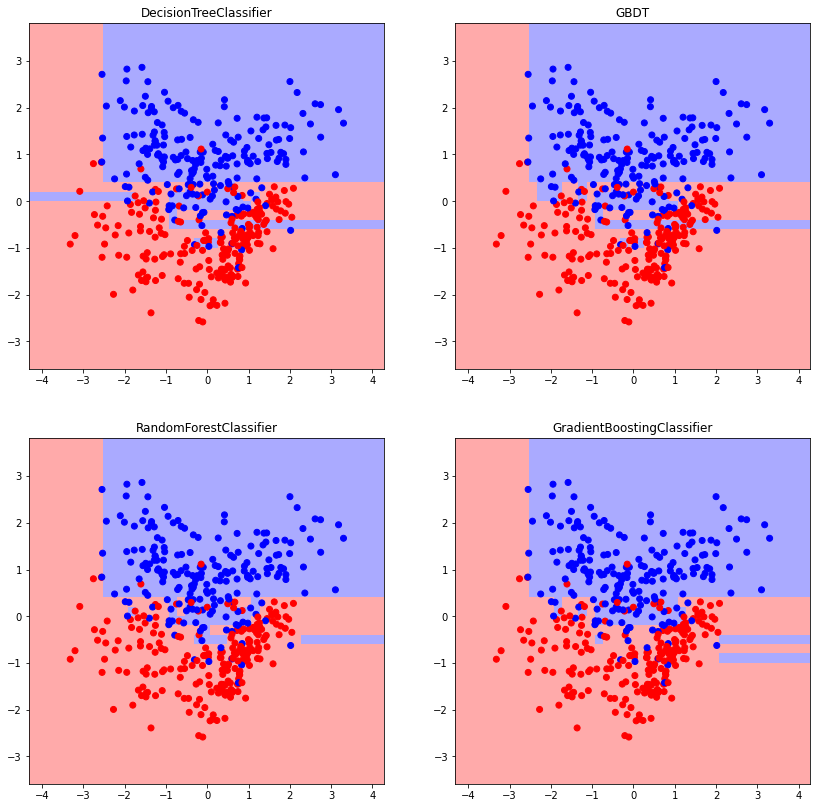

In [108]:
fig, axes = plt.subplots(2, 2, figsize=(14, 14))
for clf, ax in zip([dt, gbdt, rf, gb], axes.ravel()):
    plot_surface(X_train, y_train, clf, ax)


С помощью градиентного бустинга также можно находить выбросы в данных;

Выбросами будут те точки, градиент на которых максимален по модулю.

# Recap

1) Беггинг уменьшает разброс (из прошлого семинара)

2) Бустинг уменьшает смещение и разброс

3) Композиции тем менее эффективны, чем более коррелируют базовые алгоритмы
